In [22]:
from sklearn.model_selection import KFold
from keras.metrics import categorical_accuracy
from sklearn.utils import shuffle
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from keras import optimizers
import numpy as np
import pickle as pk
import pandas as pd
import dask.dataframe
import csv
import pdb
import scipy.io

In [23]:
#numbers describing the bci data
num_features = 64
number_of_people = 6
bci_channel_count = 11

#settings
data_name = "Fear"
use_bci_features = True

In [24]:
#load bci feature and questoinnaire data from matlab files
def flatten_bci_feature_data(raw_data, num_features):
  data_size_x = int(raw_data.shape[0] / num_features)
  data_size_y = num_features * bci_channel_count

  data = np.array([])

  for person_index in range(0, number_of_people):
    temp_data = np.zeros((data_size_x, data_size_y))

    for i in range(temp_data.shape[0]):
        lr = i * num_features
        ur = (i + 1) * num_features
        temp_data[i] = raw_data[lr:ur, :, person_index].flatten('F')
      
    #pdb.set_trace()
    data = temp_data if person_index == 0 else np.append(data, temp_data, axis=0)
  
  return data

def process_raw_bci_data(data_raw, num_input):
    #We are going to apply minmax normalization separately for each channel for each person
    for person_index in range(data_raw.shape[2]):
        for channel_index in range(data_raw.shape[1]):
            values = data_raw[:, channel_index, person_index]
            data_raw[:, channel_index, person_index] = (values - values.min()) / (values.max() - values.min())

    data_size_x = int(data_raw.shape[0] / num_input)
    data_size_y = num_input * bci_channel_count

    data = np.zeros((data_size_x, data_size_y))

    for i in range(data.shape[0]):
        lr = i * num_input
        ur = (i + 1) * num_input
        data[i] = data_raw[lr:ur, :, person_index].flatten('F')

        #minmax normalization
        #data[i] = (data[i] - data[i].min()) / (data[i].max() - data[i].min())

    return data

def stretch_arr(arr, length):
    repeat = np.repeat(arr, length // len(arr) + 1)
    return repeat[-length:]

#there are only ~27 values for the moving average (which will be "strected" to the number of rows BCI data)
def process_mov_avg_data(data_raw, num_rows_bci_data):
    #MinMax normalization
    data_raw = (data_raw - data_raw.min()) / (data_raw.max() - data_raw.min())
    
    return stretch_arr(data_raw, num_rows_bci_data)

num_features = 64 if use_bci_features else 512

#"bci_feature_data" is x, questionnaire_data is y
bci_feature_data = np.array(scipy.io.loadmat(f"encoded_data_{data_name}.mat")["data"]) if use_bci_features else np.array(scipy.io.loadmat("Data.mat")["Data"][data_name][0][0]) / 10000
bci_feature_data = flatten_bci_feature_data(bci_feature_data, num_features)

questionnaire_data = scipy.io.loadmat("Questionnaire.mat")["Questionnaire"][f"{data_name}MovingAverage"][0][0]
questionnaire_data = np.array(questionnaire_data)
questionnaire_data = process_mov_avg_data(questionnaire_data, bci_feature_data.shape[0])

#"smooth" out survey data using savgol filter
window_size = 11
poly_order = 3
questionnaire_data = savgol_filter(questionnaire_data, window_size, poly_order)

In [25]:
#method for building prediction model
def build_model(input_length):
  network = models.Sequential()

  network.add(layers.Dense(256, activation="relu", input_shape=(input_length,)))
  #network.add(layers.Dropout(0.5))
  network.add(layers.Dense(128, activation="relu"))
  #network.add(layers.Dropout(0.5))
  network.add(layers.Dense(64, activation="relu"))
  #network.add(layers.Dropout(0.5))
  network.add(layers.Dense(32, activation="relu"))
  network.add(layers.Dense(1))
      
  network.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
  
  return network

---------- CROSS FOLD VALIDATION ----------

---------------------- FOLD NO 1 TRAINING BEGIN ----------------------

Epoch 1/10
372/372 [==============================] - 1s 2ms/step - loss: 0.0381 - mae: 0.1412
Epoch 2/10
372/372 [==============================] - 1s 2ms/step - loss: 0.0131 - mae: 0.0808
Epoch 3/10
372/372 [==============================] - 1s 2ms/step - loss: 0.0087 - mae: 0.0669
Epoch 4/10
372/372 [==============================] - 1s 2ms/step - loss: 0.0080 - mae: 0.0606
Epoch 5/10
372/372 [==============================] - 1s 2ms/step - loss: 0.0050 - mae: 0.0482
Epoch 6/10
372/372 [==============================] - 1s 2ms/step - loss: 0.0041 - mae: 0.0432
Epoch 7/10
372/372 [==============================] - 1s 2ms/step - loss: 0.0037 - mae: 0.0403
Epoch 8/10
372/372 [==============================] - 1s 2ms/step - loss: 0.0049 - mae: 0.0460
Epoch 9/10
372/372 [==============================] - 1s 2ms/step - loss: 0.0036 - mae: 0.0400
Epoch 10/10
6/6 [===========

IndexError: list index out of range

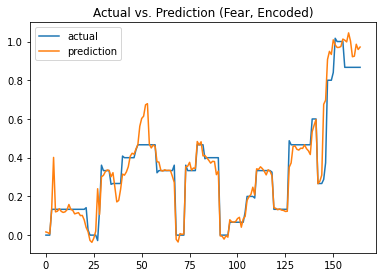

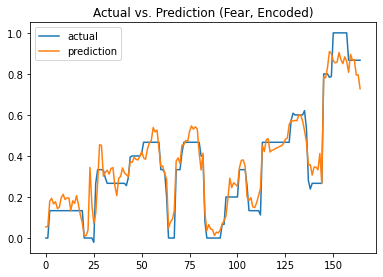

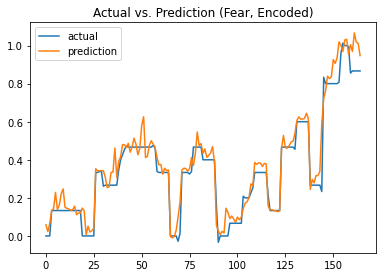

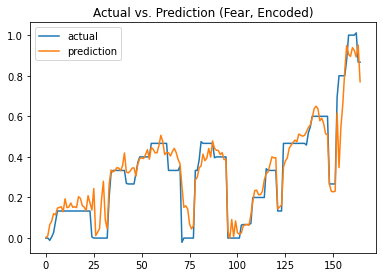

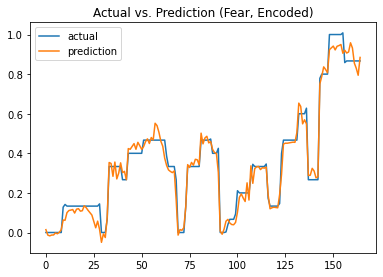

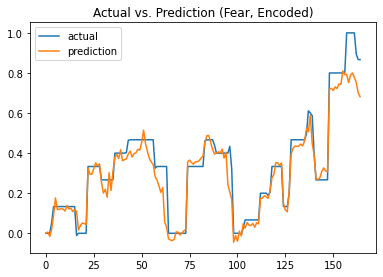

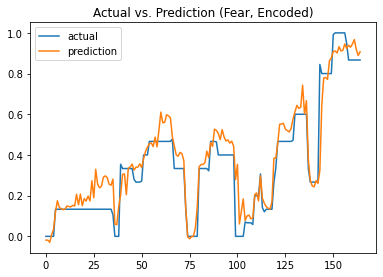

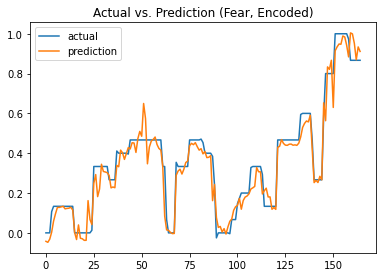

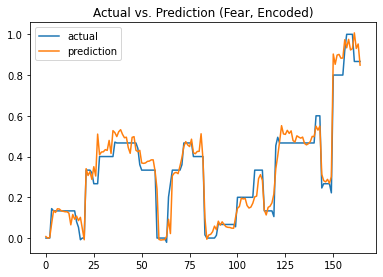

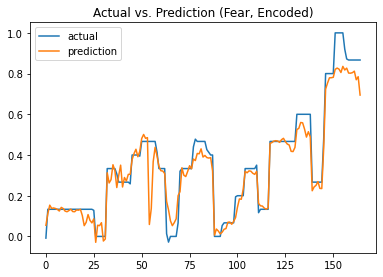

In [26]:
#train model with kfold validation
kfold_splits = 10
epochs = 10
batch_size = 4

x = bci_feature_data
y = questionnaire_data

graph_fold_results = True

kFold = KFold(n_splits=10, shuffle=True)

print('---------- CROSS FOLD VALIDATION ----------\n')

loss_arr = []
score_arr = []

fold_num = 1
for train, test in kFold.split(x, y):
  model = build_model(num_features * bci_channel_count)

  print(f'---------------------- FOLD NO {fold_num} TRAINING BEGIN ----------------------\n')

  model.fit(x[train], y[train], batch_size=batch_size, epochs=epochs)
  scores = model.evaluate(x[test], y[test])

  loss_arr.append(scores[0])
  loss_arr.append(scores[1])

  print(f'---------------------- FOLD NO {fold_num} TRAINING END ----------------------\n')

  if not graph_fold_results: 
      continue
  
  test_pred = model.predict(x[test])
  
  fold_results_fig = plt.figure()
  ax = fold_results_fig.add_axes([0.1,0.1,0.8,0.8])
  ax.set_title(f"Actual vs. Prediction ({data_name}, {'Encoded' if use_bci_features else 'Raw'})")
  
  ax.plot(np.arange(y[test].shape[0]), y[test], label="actual")
  ax.plot(np.arange(test_pred.shape[0]), test_pred, label="prediction")
  ax.legend()

  fold_num += 1

print('------------ RESULTS PER FOLD ------------')
for i in range(len(loss_arr)):
    print(f'fold #{i}. Loss: {loss_arr[i]} - Score: {score_arr[i]}')
    print('--------------')
    
print('\n------- AVG ACROSS FOLDS -------')
print(f'Avg loss: {np.mean(loss_arr)} +/- {np.std(loss_arr)}')
print(f'Avg score: {np.mean(score_arr)} +/- {np.std(score_arr)}\n')